# Imports

In [1]:
from INMET import INMET
from ONI import ONI
from TratamentoDados import gerar_daily_dataframe


In [2]:
import calendar
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import math

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
from pathlib import Path
from datetime import datetime, timedelta


In [4]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


In [5]:
sliding_window_size = 25
start_period_train = '2002-01-01'
end_period_train = f'2013-12-31'
end_period_predict = f'2014-12-31'
num_predict_periods = 365

# Tratamento dados INMET

In [6]:
#inmet = INMET()
#inmet.extrair_dados_inmet()

# Tratamento dados ONI

In [7]:
oni = ONI()
oni.extrair_dados()

# Criação de dataframe

In [8]:
def list_cities(diretorio_regiao):
    directories = []
    dir_path = Path(diretorio_regiao)

    cidades = [item.name for item in dir_path.iterdir() if item.is_dir()]

    return cidades

In [9]:
def anexacao_dados_medidor(diretorio_regiao):
    cidades = list_cities(diretorio_regiao)

    for cidade in cidades:
        diretorio_completo = f"{diretorio_regiao}{cidade}/"
        dir_path = Path(diretorio_completo)

        files = [item.name for item in dir_path.iterdir() if item.is_file()]

        column_names = None

        rows = []

        for file_name in files:
            with open(f'{diretorio_completo}{file_name}', 'r') as csv_file:
                for row in csv_file.readlines():
                    if 'data' in row.lower():
                        if column_names is None:
                            column_names = row.split(',')
                            continue
                    
                    else:
                        rows.append(row.split(','))

        with open(f'{diretorio_regiao}{cidade}.csv', 'w') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(column_names)

            for row in rows:
                writer.writerow(row)


In [10]:
#anexacao_dados_medidor('/home/iury/Especializacao/Modelos_Machine_Learning/INMET/RS/')

In [11]:
daily_df = gerar_daily_dataframe('/home/iury/Especializacao/Modelos_Machine_Learning/INMET/RS/PORTO ALEGRE.csv')

# Analise dos dados

In [12]:
df_periodo = daily_df.loc[(daily_df.index >= start_period_train) & (daily_df.index <= end_period_train)]

In [13]:
def plot_histogram(xvalues, yvalues, title, xlabel, ylabel):
    plt.bar(xvalues, yvalues)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [14]:
def plot_boxplot_by(df, column, by_column, title, xlabel, ylabel):
    df.boxplot(column=column, by=by_column, grid=False)
    plt.title(title)
    plt.suptitle('')  # Remove o título padrão
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)    

In [15]:
def days_in_year(year):
    return 366 if calendar.isleap(year) else 365

In [16]:
years = df_periodo.index.year.unique()

list_missing_values = []
list_missing_values_pct = []

for year in years:
    list_missing_values.append(days_in_year(year) - len(df_periodo.loc[df_periodo.index.year == year]))
    list_missing_values_pct.append((list_missing_values[-1]/days_in_year(year))*100)

In [17]:
def detect_num_outliers(df, coluna, by_coluna=''):
    list_unique_values = df[by_coluna].unique()
    
    dict_num_outliers = {}
    
    for value in list_unique_values:
        df_filtered = df.loc[df[by_coluna] == value]
        
        q1 = df_filtered[coluna].quantile(0.25)
        q3 = df_filtered[coluna].quantile(0.75)
        
        iqr = q3 - q1
        
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        numero_linhas = len(df_filtered.loc[((df_filtered[coluna] < lower_bound) | (df_filtered[coluna] > upper_bound))])
        
        dict_num_outliers[value] = numero_linhas
    
    return dict_num_outliers

In [18]:
dict_outliers_year = detect_num_outliers(df_periodo, 'precipitacao', 'year')

In [19]:
list_precipitacao_year = []
list_pct_outlier_precipitacao_year = []
list_pct_dias_precipitacao_year = []
for year in years:
    list_precipitacao_year.append(len(df_periodo.loc[(df_periodo['year'] == year) & (df_periodo['precipitacao'] > 0)]))
    list_pct_outlier_precipitacao_year.append((dict_outliers_year[year]/list_precipitacao_year[-1]) * 100)
    list_pct_dias_precipitacao_year.append((days_in_year(year) - list_precipitacao_year[-1])/(days_in_year(year)) * 100)
    

In [20]:
def plot_scatter(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

## Dados Faltantes

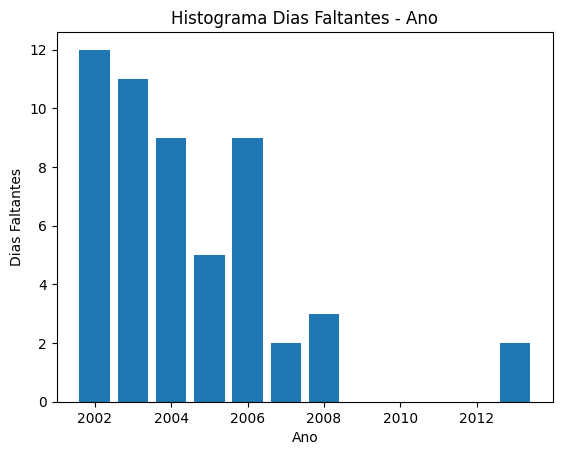

In [21]:
plot_histogram(years, list_missing_values, 'Histograma Dias Faltantes - Ano', 'Ano', 'Dias Faltantes')

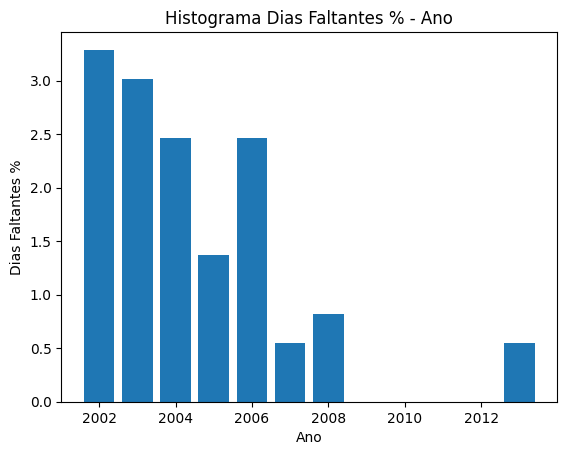

In [22]:
plot_histogram(years, list_missing_values_pct, 'Histograma Dias Faltantes % - Ano', 'Ano', 'Dias Faltantes %')

## Analise Precipitacao - Periodo de Treino

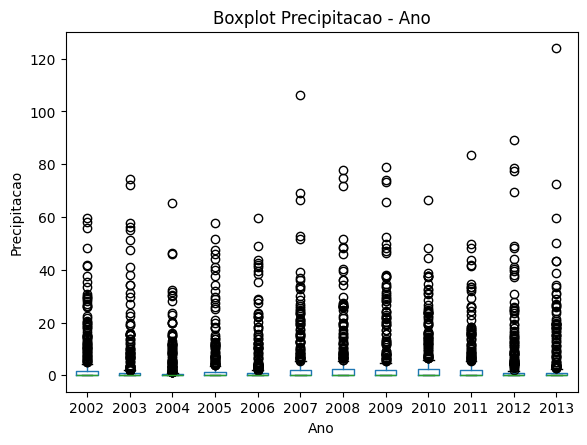

In [23]:
plot_boxplot_by(df_periodo, 'precipitacao', 'year', 'Boxplot Precipitacao - Ano', 'Ano', 'Precipitacao')

### Analise quantidade de dias com precipitacao

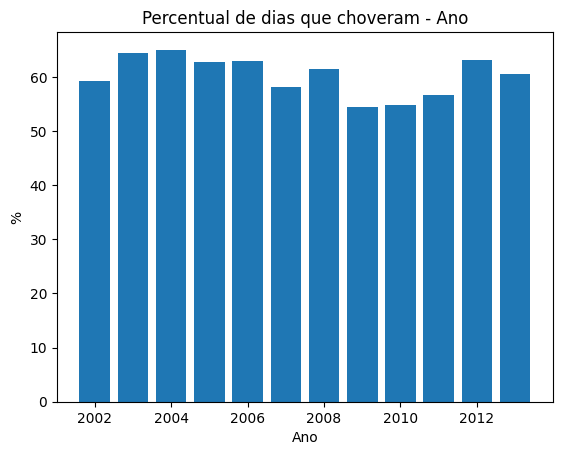

In [24]:
plot_histogram(years, list_pct_dias_precipitacao_year, 'Percentual de dias que choveram - Ano', 'Ano', '%')

### Comparacao precipitacao x outliers

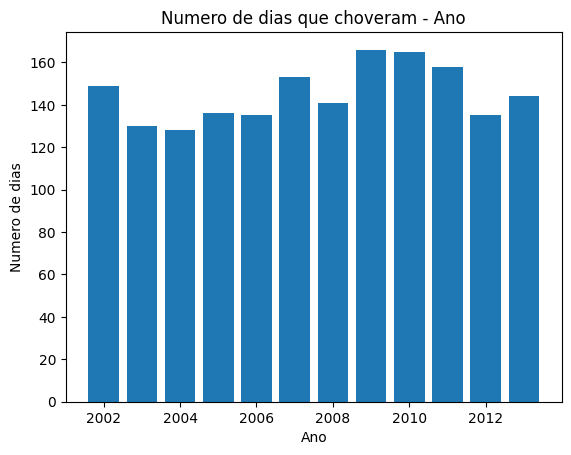

In [25]:
plot_histogram(years, list_precipitacao_year, 'Numero de dias que choveram - Ano', 'Ano', 'Numero de dias')

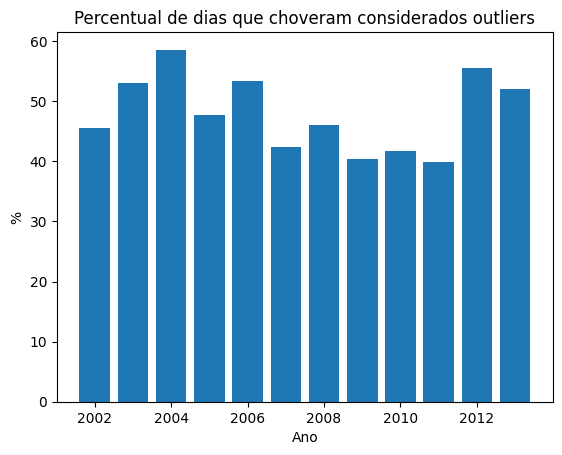

In [26]:
plot_histogram(years, list_pct_outlier_precipitacao_year, 'Percentual de dias que choveram considerados outliers', 'Ano', '%')

## Analise de Features

### Umidade

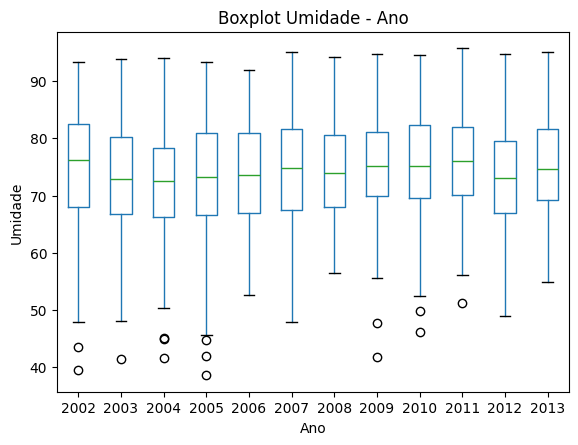

In [27]:
plot_boxplot_by(df_periodo, 'umidade', 'year', 'Boxplot Umidade - Ano', 'Ano', 'Umidade')

### Radiação Global

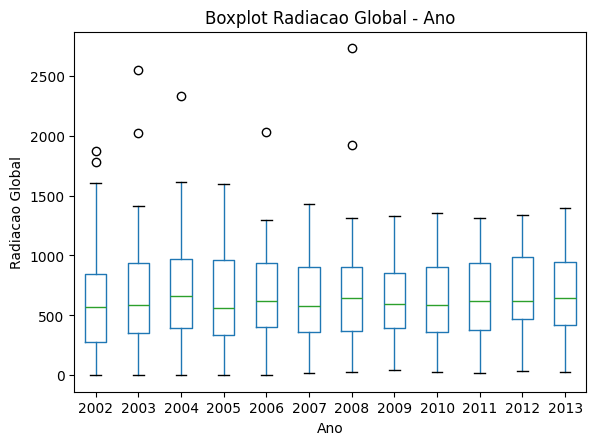

In [28]:
plot_boxplot_by(df_periodo, 'radiacao_global', 'year', 'Boxplot Radiacao Global - Ano', 'Ano', 'Radiacao Global')

### Rajada Maxima Vento

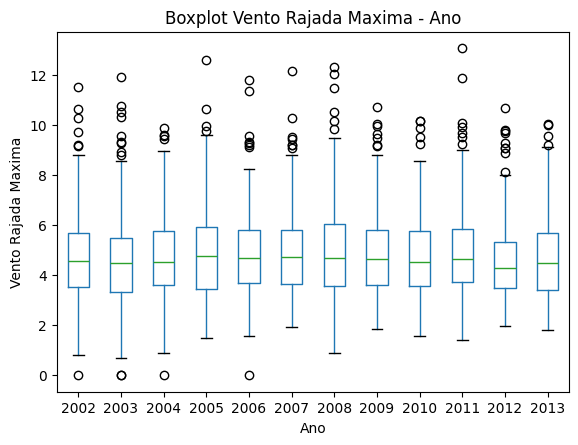

In [29]:
plot_boxplot_by(df_periodo, 'vento_rajada_maxima', 'year', 'Boxplot Vento Rajada Maxima - Ano', 'Ano', 'Vento Rajada Maxima')

### Temperatura Orvalho

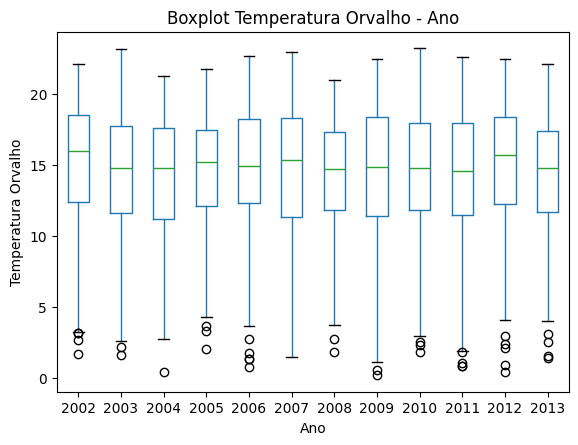

In [30]:
plot_boxplot_by(df_periodo, 'temperatura_ponto_orvalho', 'year', 'Boxplot Temperatura Orvalho - Ano', 'Ano', 'Temperatura Orvalho')

### Precipitacao x Mes

In [31]:
df_periodo.head()

,precipitacao,pressao_atmosferica,radiacao_global,temperatura_do_ar,temperatura_ponto_orvalho,umidade,direcao_vento_horario,vento_rajada_maxima,vento_velocidade_horaria,year,month,day,la_nina,el_nino,num_observacoes
year_month_day,,,,,,,,,,,,,,,
2002-01-01,0.0,956.041667,1117.291667,25.050000,18.550000,70.458333,235.791667,4.816667,1.583333,2002,1,1,1,1,24
2002-01-02,0.8,999.566667,846.222222,25.294444,18.200000,65.444444,244.944444,4.427778,1.427778,2002,1,2,1,1,18
2002-01-03,0.0,1003.133333,1043.166667,24.491667,17.733333,67.666667,208.750000,4.779167,1.850000,2002,1,3,1,1,24
2002-01-04,0.0,1005.333333,1056.208333,24.316667,18.283333,70.166667,170.083333,5.237500,2.058333,2002,1,4,1,1,24
2002-01-05,0.0,1006.525000,750.416667,23.645833,18.991667,75.583333,105.791667,6.883333,2.816667,2002,1,5,1,1,24


In [32]:
dados = []
monthes = df_periodo['month'].unique()
for year in years:
    dados_year = []
    
    for month in monthes:
        precipitacao_total = df_periodo.loc[(df_periodo['year'] == year) & (df_periodo['month'] == month)]['precipitacao'].sum()
        dados_year.append(precipitacao_total)
    
    dados.append(dados_year)

In [33]:
#def generate_random_colors(n):
#    colors = []
#    for _ in range(n):
#        color = "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
#        colors.append(color)
#    return colors

In [34]:
rows = 3
columns = math.ceil(len(years)/rows)


In [35]:
def plot_scatter_grid(x, y, rows, cols, title, xlabel, ylabel, value_chart):
    fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
    
    for i in range(len(value_chart)):
        row = i // cols
        col = i % cols

        title_str = title.replace('X', f'{value_chart[i]}')
        
        axes[row, col].scatter(x, y[i], color='blue')  
        axes[row, col].set_title(title_str)
        axes[row, col].set_xlabel(xlabel)      
        axes[row, col].set_ylabel(ylabel)
        
        axes[row, col].plot(x, y[i], color='blue', linestyle='-')
 
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

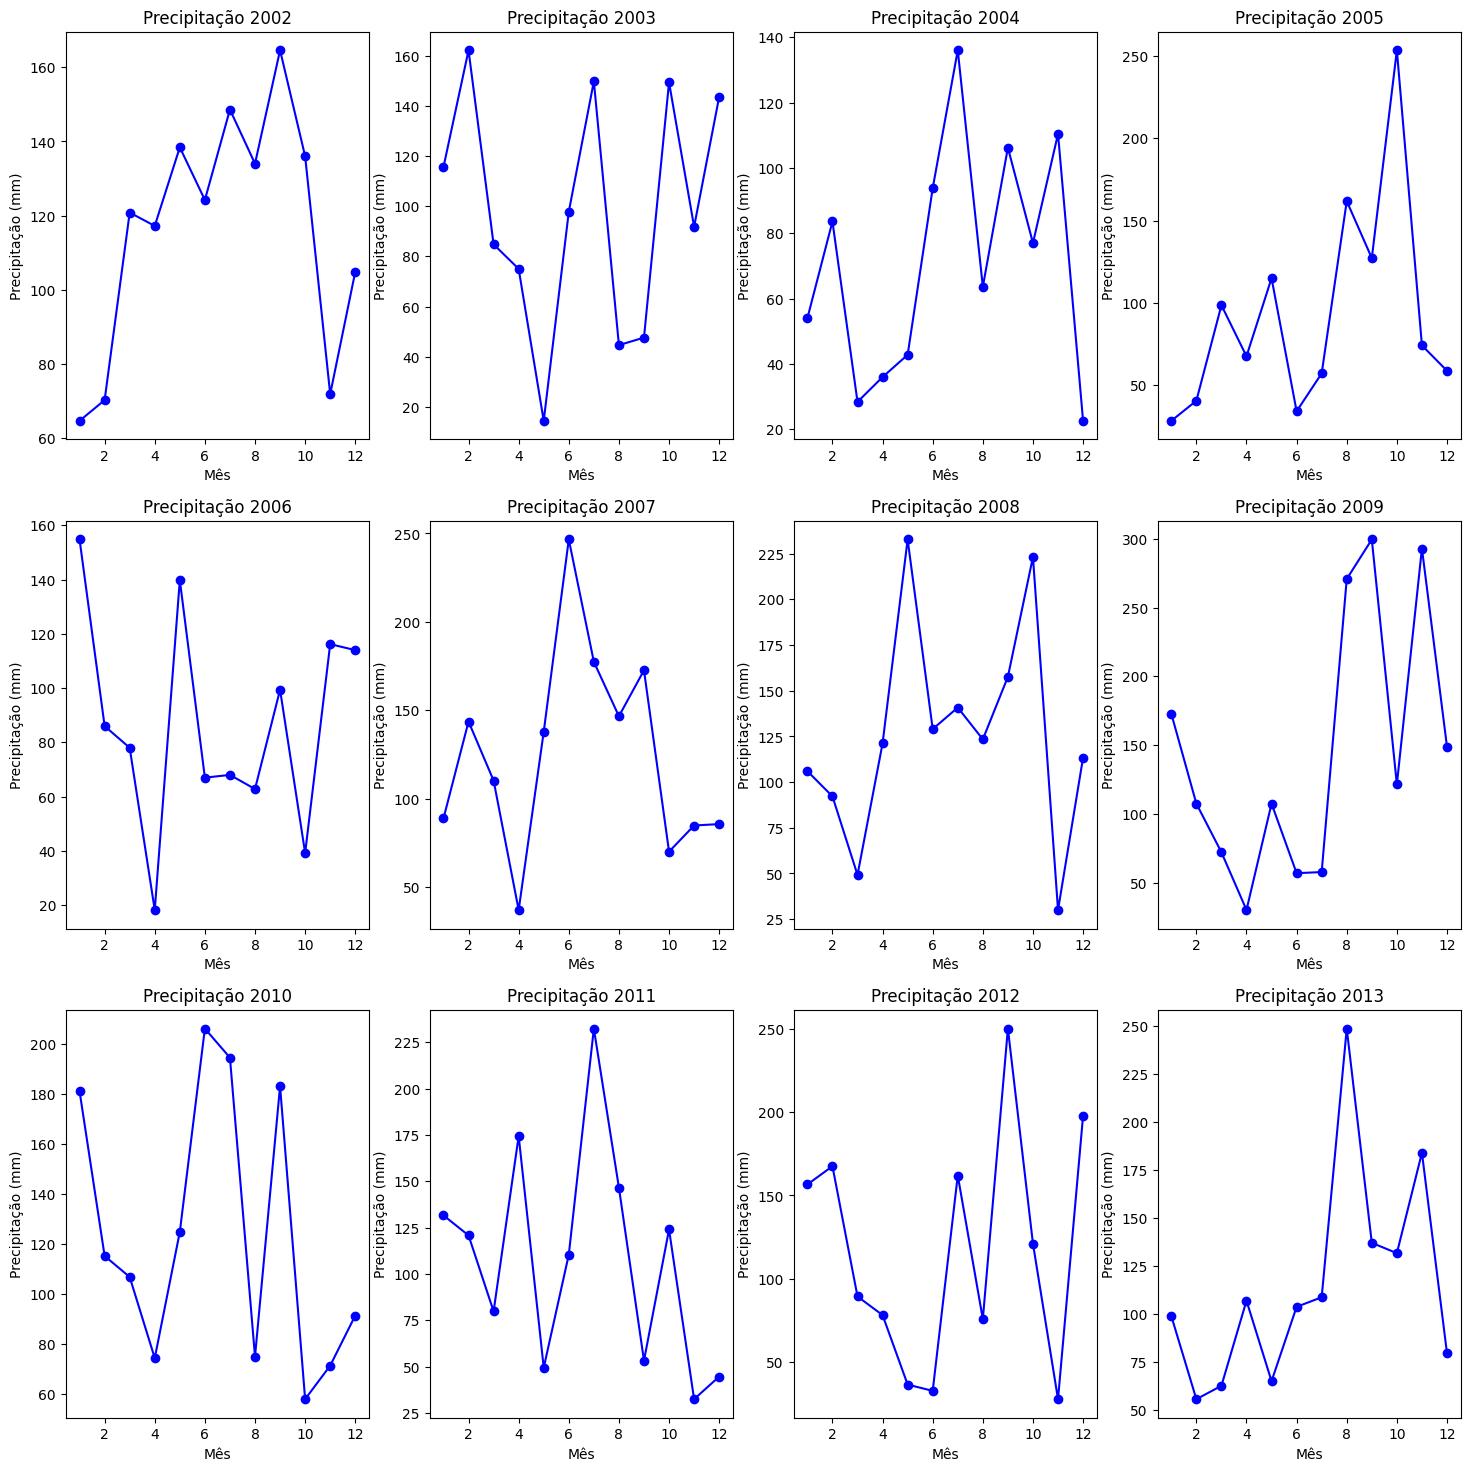

In [36]:
plot_scatter_grid(monthes, dados, rows, columns, 'Precipitação X', 'Mês', 'Precipitação (mm)', years)

# Seleção de features

In [37]:
def plot_heatmap(matriz_correlacao, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

In [38]:
matriz_correlacao = daily_df.corr()

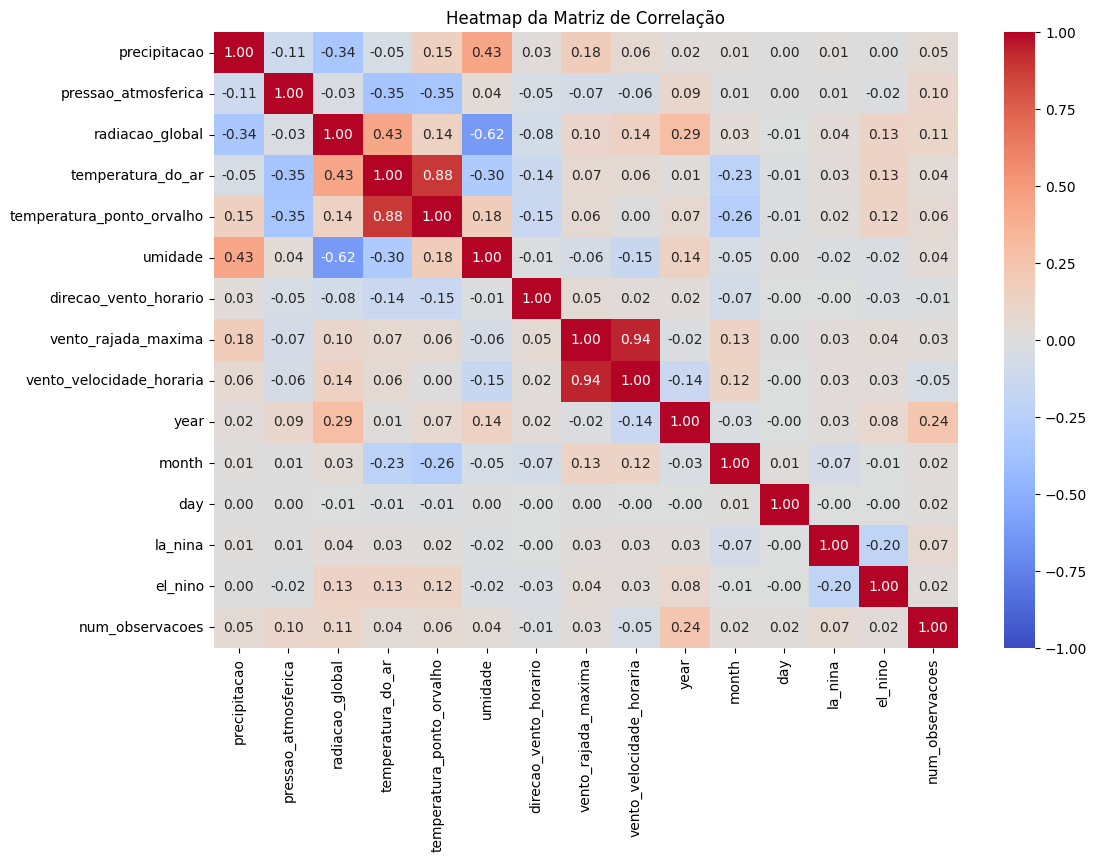

In [39]:
plot_heatmap(matriz_correlacao, 'Heatmap da Matriz de Correlação')

In [40]:
#Eliminar features com correlação absoluta baixa
df_tratado = daily_df.drop(columns=['year', 'month', 'day', 'la_nina', 'el_nino', 'num_observacoes', 'vento_velocidade_horaria', 'direcao_vento_horario'])

#Eliminar features com alta correlação com outras features
#df_tratado = df_tratado.drop(columns=['temperatura_do_ar', 'radiacao_global'])

In [41]:
matriz_correlacao = df_tratado.corr()

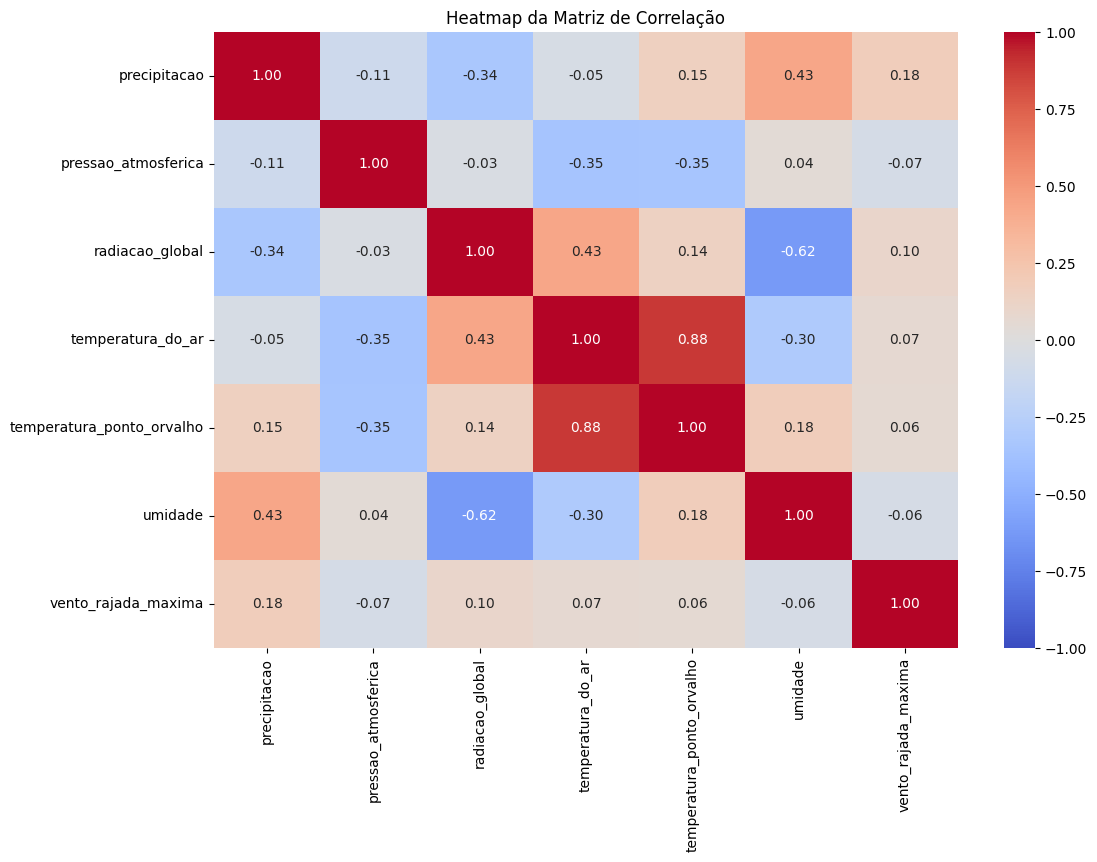

In [42]:
plot_heatmap(matriz_correlacao, 'Heatmap da Matriz de Correlação')

# Criar DataFrame Series Temporais

In [43]:
def preencher_datas_faltantes(df, period = 1):
    coluna_datetime = 'year_month_day'
    
#    indice_datetime = df.columns.get_loc(coluna_datetime)
    data_atual = df.index[0]#[coluna_datetime]
        
    list_dataframe = []
    
    datas = []
    
    for i in range(len(df)):
        data_row = df.index[i]#[coluna_datetime]
        
        while data_atual.date() != data_row.date():
            if list_dataframe:
                list_dataframe.append(list_dataframe[-1])
#                list_dataframe[-1].index = data_atual
                datas.append(data_atual)    
            data_atual = data_atual + timedelta(days=1)
            
        list_dataframe.append(df.iloc[i].tolist())
        
        datas.append(data_atual)
        
        data_atual = data_atual + timedelta(days=1)

    df_treated = pd.DataFrame(list_dataframe, columns = df.columns)

    df_treated.index = datas
        
    df_treated = df_treated.dropna()
    
    df_treated.reset_index(inplace=True)
    
    df_treated = df_treated.rename(columns={'index': 'year_month_day'})
        
    return df_treated
            
    
    

In [44]:
def sliding_windows_df(df, period=1, scaler=StandardScaler()):
    sw_df = pd.DataFrame()

    set_of_features_sliding_window = {'pressao_atmosferica', 'temperatura_ponto_orvalho', 'umidade', 'vento_rajada_maxima', 'precipitacao'}
    target = 'precipitacao'
    
    sw_df['target'] = df['precipitacao'].shift(-(period+1)).values    
    
    for feature in set_of_features_sliding_window:
            
        for i in range(1, period+1):
            coluna = f'{feature}_{period-i+1}'
            sw_df[coluna] = df[feature].shift(-i).values

    sw_df = sw_df.dropna()

    sw_df.set_index(df.index[period+1:], inplace=True)
        
    scaled_df = pd.DataFrame(scaler.fit_transform(sw_df), columns=sw_df.columns)
    scaled_df.set_index(sw_df.index, inplace=True)   
    
    return scaled_df

In [45]:
scaler = StandardScaler()
sw_df = sliding_windows_df(df_tratado, sliding_window_size, scaler)

/tmp/ipykernel_8237/2813195578.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sw_df[coluna] = df[feature].shift(-i).values
/tmp/ipykernel_8237/2813195578.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sw_df[coluna] = df[feature].shift(-i).values
/tmp/ipykernel_8237/2813195578.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmente

In [46]:
sw_df.head()

,target,precipitacao_25,precipitacao_24,precipitacao_23,precipitacao_22,precipitacao_21,precipitacao_20,precipitacao_19,precipitacao_18,precipitacao_17,...,temperatura_ponto_orvalho_10,temperatura_ponto_orvalho_9,temperatura_ponto_orvalho_8,temperatura_ponto_orvalho_7,temperatura_ponto_orvalho_6,temperatura_ponto_orvalho_5,temperatura_ponto_orvalho_4,temperatura_ponto_orvalho_3,temperatura_ponto_orvalho_2,temperatura_ponto_orvalho_1
year_month_day,,,,,,,,,,,,,,,,,,,,,
2000-10-18,2.289238,2.323180,1.918614,-0.380228,-0.380248,-0.380248,-0.380248,-0.380248,-0.380248,-0.129197,...,-1.438721,-0.296892,-0.314884,-0.159314,0.458445,0.514978,0.414071,-0.431079,0.268635,1.089077
2000-10-19,-0.186209,1.917605,-0.380441,-0.380228,-0.380248,-0.380248,-0.380248,-0.380248,-0.129032,-0.361078,...,-0.296569,-0.314813,-0.159251,0.458508,0.515039,0.414054,-0.431048,0.268769,1.089203,0.918369
2000-10-20,0.510010,-0.380657,-0.380441,-0.380228,-0.380248,-0.380248,-0.380248,-0.129032,-0.360924,0.489153,...,-0.314489,-0.159180,0.458568,0.515102,0.414113,-0.431059,0.268817,1.089345,0.918487,0.657119
2000-10-21,-0.379604,-0.380657,-0.380441,-0.380228,-0.380248,-0.380248,-0.129032,-0.360924,0.489348,3.329698,...,-0.158870,0.458638,0.515162,0.414176,-0.431025,0.268801,1.089412,0.918628,0.657226,0.573008
2000-10-22,-0.379604,-0.380657,-0.380441,-0.380228,-0.380248,-0.129032,-0.360924,0.489348,3.330027,-0.341755,...,0.458892,0.515232,0.414236,-0.430966,0.268855,1.089391,0.918690,0.657364,0.573111,0.256285


In [47]:
sw_df = preencher_datas_faltantes(sw_df, sliding_window_size)

In [48]:
sw_df.head()

,year_month_day,target,precipitacao_25,precipitacao_24,precipitacao_23,precipitacao_22,precipitacao_21,precipitacao_20,precipitacao_19,precipitacao_18,...,temperatura_ponto_orvalho_10,temperatura_ponto_orvalho_9,temperatura_ponto_orvalho_8,temperatura_ponto_orvalho_7,temperatura_ponto_orvalho_6,temperatura_ponto_orvalho_5,temperatura_ponto_orvalho_4,temperatura_ponto_orvalho_3,temperatura_ponto_orvalho_2,temperatura_ponto_orvalho_1
0,2000-10-18,2.289238,2.323180,1.918614,-0.380228,-0.380248,-0.380248,-0.380248,-0.380248,-0.380248,...,-1.438721,-0.296892,-0.314884,-0.159314,0.458445,0.514978,0.414071,-0.431079,0.268635,1.089077
1,2000-10-19,-0.186209,1.917605,-0.380441,-0.380228,-0.380248,-0.380248,-0.380248,-0.380248,-0.129032,...,-0.296569,-0.314813,-0.159251,0.458508,0.515039,0.414054,-0.431048,0.268769,1.089203,0.918369
2,2000-10-20,0.510010,-0.380657,-0.380441,-0.380228,-0.380248,-0.380248,-0.380248,-0.129032,-0.360924,...,-0.314489,-0.159180,0.458568,0.515102,0.414113,-0.431059,0.268817,1.089345,0.918487,0.657119
3,2000-10-21,-0.379604,-0.380657,-0.380441,-0.380228,-0.380248,-0.380248,-0.129032,-0.360924,0.489348,...,-0.158870,0.458638,0.515162,0.414176,-0.431025,0.268801,1.089412,0.918628,0.657226,0.573008
4,2000-10-22,-0.379604,-0.380657,-0.380441,-0.380228,-0.380248,-0.129032,-0.360924,0.489348,3.330027,...,0.458892,0.515232,0.414236,-0.430966,0.268855,1.089391,0.918690,0.657364,0.573111,0.256285


In [49]:
df_tratado.head(10)

,precipitacao,pressao_atmosferica,radiacao_global,temperatura_do_ar,temperatura_ponto_orvalho,umidade,vento_rajada_maxima
year_month_day,,,,,,,
2000-09-22,0.0,1014.950000,1110.850000,17.120000,10.740000,69.150000,4.950000
2000-09-23,28.0,1006.987500,810.583333,17.604167,12.916667,76.125000,4.529167
2000-09-24,23.8,1008.200000,303.250000,14.995833,11.504167,80.750000,7.358333
2000-09-25,0.0,1020.054167,986.791667,10.704167,3.300000,61.458333,7.195833
2000-09-26,0.0,1024.416667,995.750000,11.833333,4.704167,63.458333,4.679167
2000-09-27,0.0,1020.416667,952.125000,14.529167,8.725000,71.041667,4.262500
2000-09-28,0.0,1016.162500,990.708333,18.570833,11.812500,68.916667,3.912500
2000-09-29,0.0,1014.120833,971.916667,18.954167,12.091667,66.416667,3.483333
2000-09-30,0.0,1012.850000,663.208333,18.233333,15.429167,84.625000,4.350000


In [50]:
sw_df.head()

,year_month_day,target,precipitacao_25,precipitacao_24,precipitacao_23,precipitacao_22,precipitacao_21,precipitacao_20,precipitacao_19,precipitacao_18,...,temperatura_ponto_orvalho_10,temperatura_ponto_orvalho_9,temperatura_ponto_orvalho_8,temperatura_ponto_orvalho_7,temperatura_ponto_orvalho_6,temperatura_ponto_orvalho_5,temperatura_ponto_orvalho_4,temperatura_ponto_orvalho_3,temperatura_ponto_orvalho_2,temperatura_ponto_orvalho_1
0,2000-10-18,2.289238,2.323180,1.918614,-0.380228,-0.380248,-0.380248,-0.380248,-0.380248,-0.380248,...,-1.438721,-0.296892,-0.314884,-0.159314,0.458445,0.514978,0.414071,-0.431079,0.268635,1.089077
1,2000-10-19,-0.186209,1.917605,-0.380441,-0.380228,-0.380248,-0.380248,-0.380248,-0.380248,-0.129032,...,-0.296569,-0.314813,-0.159251,0.458508,0.515039,0.414054,-0.431048,0.268769,1.089203,0.918369
2,2000-10-20,0.510010,-0.380657,-0.380441,-0.380228,-0.380248,-0.380248,-0.380248,-0.129032,-0.360924,...,-0.314489,-0.159180,0.458568,0.515102,0.414113,-0.431059,0.268817,1.089345,0.918487,0.657119
3,2000-10-21,-0.379604,-0.380657,-0.380441,-0.380228,-0.380248,-0.380248,-0.129032,-0.360924,0.489348,...,-0.158870,0.458638,0.515162,0.414176,-0.431025,0.268801,1.089412,0.918628,0.657226,0.573008
4,2000-10-22,-0.379604,-0.380657,-0.380441,-0.380228,-0.380248,-0.129032,-0.360924,0.489348,3.330027,...,0.458892,0.515232,0.414236,-0.430966,0.268855,1.089391,0.918690,0.657364,0.573111,0.256285


In [51]:
sw_df.columns

Index(['year_month_day', 'target', 'precipitacao_25', 'precipitacao_24',
       'precipitacao_23', 'precipitacao_22', 'precipitacao_21',
       'precipitacao_20', 'precipitacao_19', 'precipitacao_18',
       ...
       'temperatura_ponto_orvalho_10', 'temperatura_ponto_orvalho_9',
       'temperatura_ponto_orvalho_8', 'temperatura_ponto_orvalho_7',
       'temperatura_ponto_orvalho_6', 'temperatura_ponto_orvalho_5',
       'temperatura_ponto_orvalho_4', 'temperatura_ponto_orvalho_3',
       'temperatura_ponto_orvalho_2', 'temperatura_ponto_orvalho_1'],
      dtype='object', length=127)

In [52]:
sw_df.corr()

,year_month_day,target,precipitacao_25,precipitacao_24,precipitacao_23,precipitacao_22,precipitacao_21,precipitacao_20,precipitacao_19,precipitacao_18,...,temperatura_ponto_orvalho_10,temperatura_ponto_orvalho_9,temperatura_ponto_orvalho_8,temperatura_ponto_orvalho_7,temperatura_ponto_orvalho_6,temperatura_ponto_orvalho_5,temperatura_ponto_orvalho_4,temperatura_ponto_orvalho_3,temperatura_ponto_orvalho_2,temperatura_ponto_orvalho_1
year_month_day,1.000000,0.024792,0.009180,0.027714,0.021879,0.024302,0.024013,0.028413,0.028674,0.028638,...,0.053146,0.052139,0.052089,0.052537,0.053765,0.053980,0.054748,0.056094,0.054848,0.056708
target,0.024792,1.000000,0.027754,0.014093,0.016765,-0.003173,0.016365,0.003049,0.012061,-0.000178,...,-0.031814,-0.015323,-0.010711,-0.009351,-0.008812,-0.012790,-0.014737,0.004095,0.040693,0.107358
precipitacao_25,0.009180,0.027754,1.000000,0.160593,0.042075,0.007154,0.001703,-0.006865,0.021132,0.021328,...,-0.012867,-0.018311,-0.021799,-0.014532,-0.010930,-0.004129,-0.018483,-0.020692,-0.015668,-0.006017
precipitacao_24,0.027714,0.014093,0.160593,1.000000,0.161696,0.018358,-0.013551,-0.009377,-0.010956,0.024642,...,-0.005988,-0.010710,-0.010294,-0.013472,-0.008871,-0.004951,0.000979,-0.007889,-0.014694,-0.008359
precipitacao_23,0.021879,0.016765,0.042075,0.161696,1.000000,0.168585,0.021186,-0.012267,-0.010379,-0.012068,...,-0.004201,-0.010514,-0.013835,-0.011391,-0.014331,-0.010021,-0.006606,0.000682,-0.008818,-0.012048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
temperatura_ponto_orvalho_5,0.053980,-0.012790,-0.004129,-0.004951,-0.010021,-0.014105,-0.009236,-0.011487,-0.006141,-0.002784,...,0.538323,0.550652,0.582394,0.669830,0.844863,1.000000,0.846820,0.671697,0.585300,0.551443
temperatura_ponto_orvalho_4,0.054748,-0.014737,-0.018483,0.000979,-0.006606,-0.010076,-0.013270,-0.011325,-0.009010,-0.005875,...,0.525025,0.537878,0.550465,0.583668,0.669826,0.846820,1.000000,0.846488,0.672358,0.585427
temperatura_ponto_orvalho_3,0.056094,0.004095,-0.020692,-0.007889,0.000682,-0.005514,-0.010164,-0.014016,-0.009083,-0.009034,...,0.510922,0.526177,0.539150,0.552196,0.583282,0.671697,0.846488,1.000000,0.847148,0.671733
temperatura_ponto_orvalho_2,0.054848,0.040693,-0.015668,-0.014694,-0.008818,0.000950,-0.006139,-0.010691,-0.014158,-0.008236,...,0.498985,0.511384,0.526430,0.539009,0.550057,0.585300,0.672358,0.847148,1.000000,0.844227


# Treinamento Modelos

In [53]:
def selecionar_periodo_treinamento(df, start_year, end_year):
    return df.loc[f'{start_year}-01-01':f'{end_year}-12-31']

In [54]:
def prox_timedate(ultimo_datetime, acrescimo_dias):
    return ultimo_datetime + timedelta(days=1)

In [55]:
colunas = [col for col in sw_df.columns if (('precipitacao' not in col) and ('target' != col))]

In [119]:
def plot_grafico(series, labels, lw_list, colors, xlabel='', ylabel=''):
    plt.figure(dpi=300,figsize=(15,5))
    for i in range(0, len(series)):
        plt.plot(series[i], label=labels[i], lw=lw_list[i], color=colors[i])

    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)

In [57]:
target_total_period = sw_df[(sw_df['year_month_day'] >= start_period_train) & (sw_df['year_month_day'] <= end_period_predict)]['target'].values

In [58]:
def ml_model(estrategia, num_features=1, n_jobs=8):
    
    if estrategia == 'xgb':
        return XGBRegressor(n_jobs=n_jobs)
    elif estrategia == 'linear_regression':
        return LinearRegression(n_jobs=n_jobs)
    elif estrategia == 'random_forest':
        return RandomForestRegressor(n_jobs=n_jobs)


In [59]:
def predicao(df, start_period_train, end_period_train, num_predict_periods, sliding_window_size, estrategia):
    colunas = [col for col in sw_df.columns if 'year' not in col]
    
    features = [col for col in colunas if ('target' != col and 'precipitacao' not in col)]
    
    df_period = df[(df['year_month_day'] >= start_period_train) & (df['year_month_day'] <= end_period_train)]
        
    datas = df_period['year_month_day'].to_list()
    df_period = df_period.drop(columns=['year_month_day'])  
        
    for i in range(1, num_predict_periods + 1):
        X = df_period.drop(columns=['target']).values
        Y = df_period['target'].values
        
        model=ml_model(estrategia, X.shape[1])
        model.fit(X,Y)
    
        prox_day = prox_timedate(datas[-1], 1)
        datas.append(prox_day)
        
        date_str = prox_day.strftime('%Y-%m-%d')
        
        day_row = df[df['year_month_day'] == date_str]
        
        row_vazio = day_row.empty
        
        if day_row.empty:
            last_row = df_period.iloc[[-1]]

            df_period = pd.concat([df_period, last_row], ignore_index=True) 
            
            continue           
                
        last_row_dict = {col: day_row[col].values[0] for col in colunas}
                
        prox_row = {feature: last_row_dict[feature] for feature in features}  
        
        for i in range(1,  sliding_window_size + 1):
            coluna = f'precipitacao_{i}'
            
            if i == 1:
                prox_row[coluna] = last_row_dict['target']
            else:
                coluna_last_row = f'precipitacao_{i-1}'
                prox_row[coluna] = last_row_dict[coluna_last_row]
                
        list_prox_row = [prox_row[col] for col in colunas if col != 'target']
        
        predict_value = model.predict(np.array([list_prox_row]))
        
        prox_row['target'] = predict_value
        
        new_complete_row = [prox_row[col] if col != 'target' else predict_value for col in colunas]
        
        row_df = pd.DataFrame([new_complete_row],columns=df_period.columns)
        df_period=pd.concat([df_period, row_df],ignore_index=True)
    
    return df_period

In [60]:
original_value = sw_df[(sw_df['year_month_day'] > end_period_train) & (sw_df['year_month_day'] <= end_period_predict)]['target']

In [61]:
def print_metricas_avaliacao(series_original, series_predicao):
    mae = mean_absolute_error(series_original, series_predicao)
    mse = mean_squared_error(series_original, series_predicao)
    rmse = root_mean_squared_error(series_original, series_predicao)
    r2 = r2_score(series_original, series_predicao)    
    
    print(f'MAE: {mae}' )
    print(f'MSE: {mse}' )
    print(f'RMSE: {rmse}' )
    print(f'R2: {r2}' )

## XGBRegressor

In [62]:
df_period_xgb = predicao(sw_df, start_period_train, end_period_train, num_predict_periods, sliding_window_size, 'xgb')

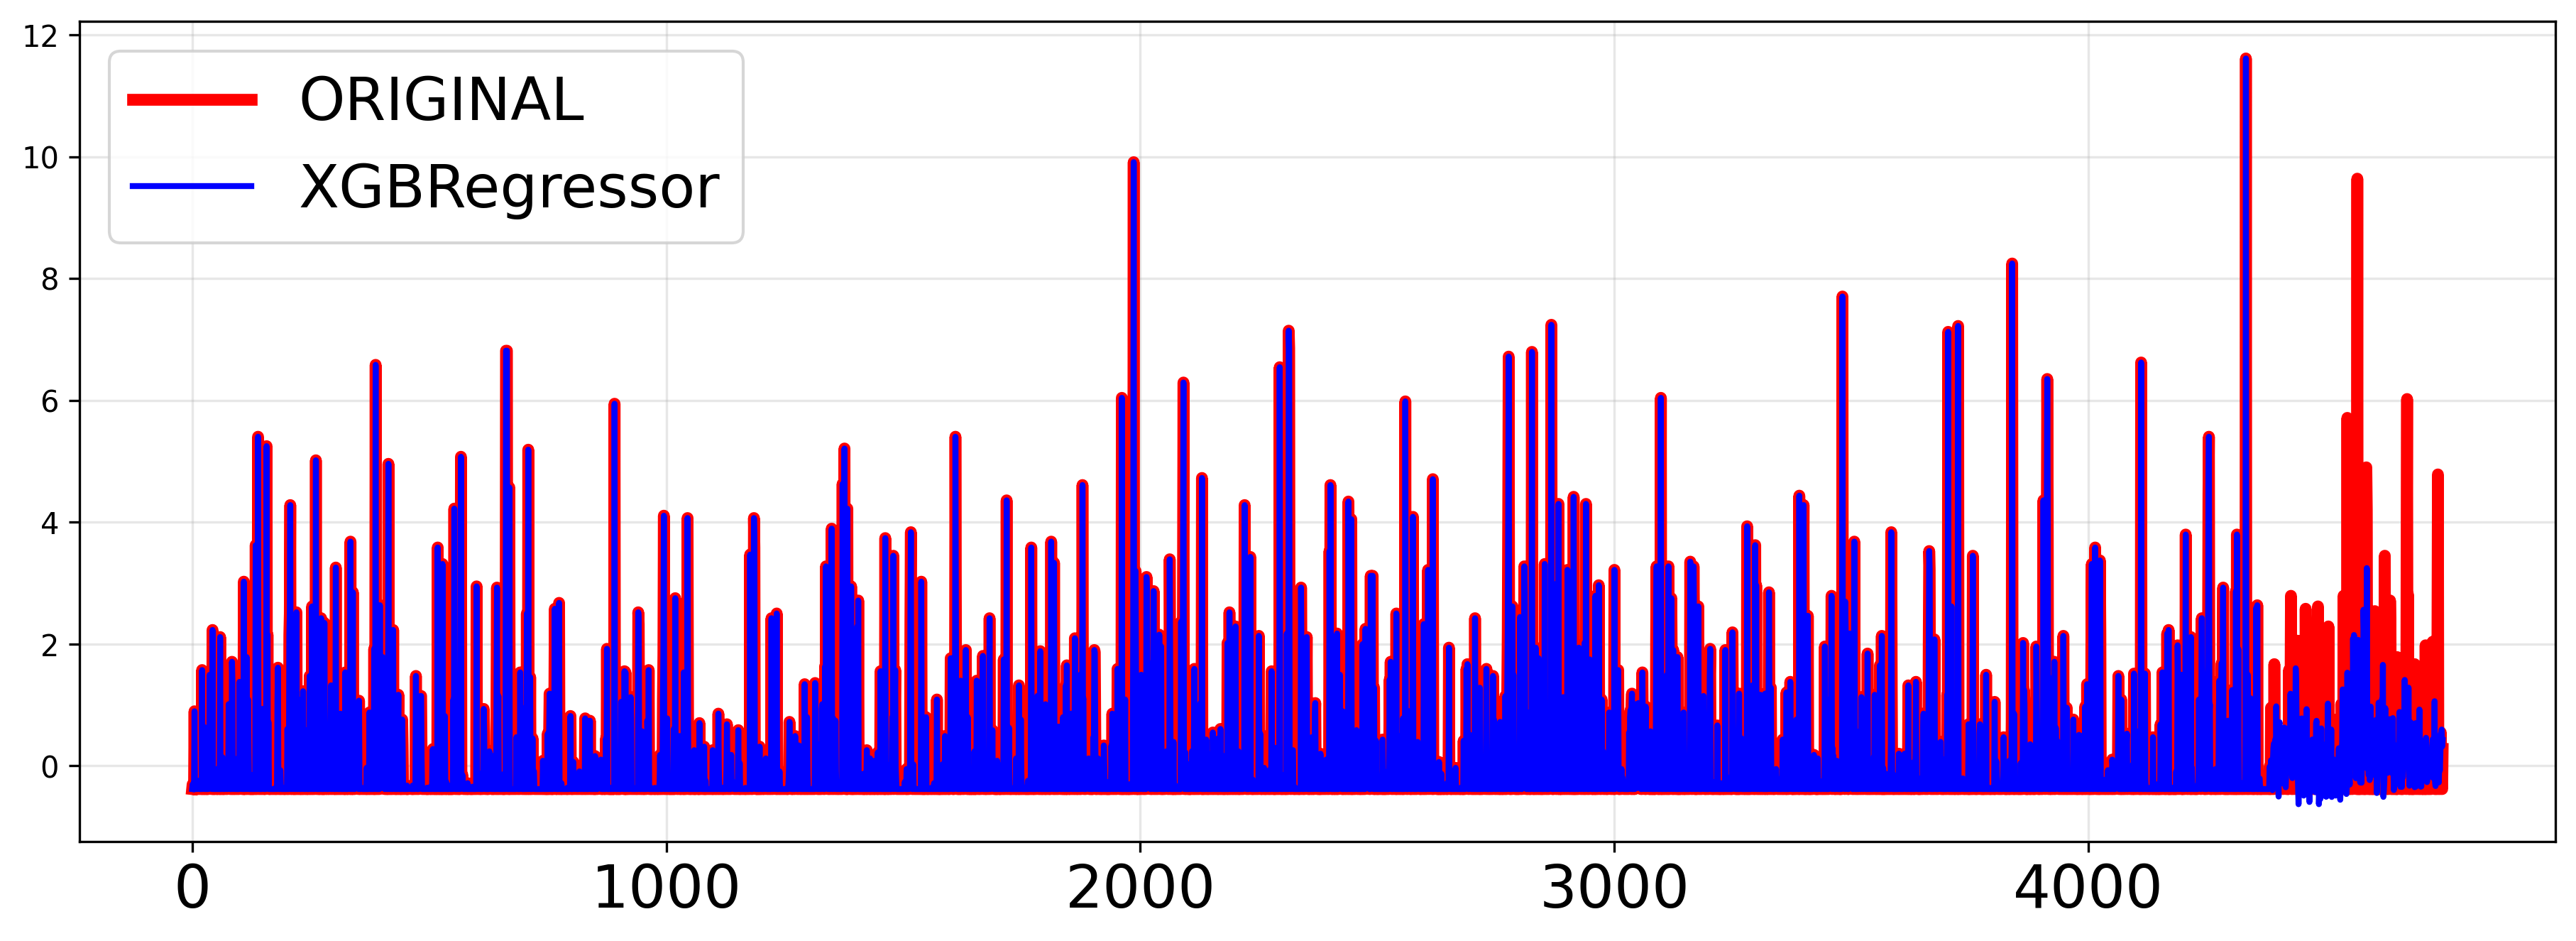

In [63]:
plot_grafico(series=[target_total_period, df_period_xgb['target']], labels=['ORIGINAL', 'XGBRegressor'], lw_list=[4, 2], colors=['red', 'blue'])

In [64]:
predicted_value_xgbregressor = df_period_xgb.iloc[-365:]['target'].apply(lambda x : x[0])

In [65]:
print_metricas_avaliacao(original_value, predicted_value_xgbregressor)

MAE: 0.6240558574753227
MSE: 1.0818083252175805
RMSE: 1.0401001515323323
R2: 0.11080045691687801


In [66]:
original_value.describe()

count    365.000000
mean       0.093921
std        1.104514
min       -0.379604
25%       -0.379604
50%       -0.379604
75%       -0.031494
max        9.638222
Name: target, dtype: float64

## Linear Regression

In [67]:
df_period_linear_regression = predicao(sw_df, start_period_train, end_period_train, num_predict_periods, sliding_window_size, 'linear_regression')

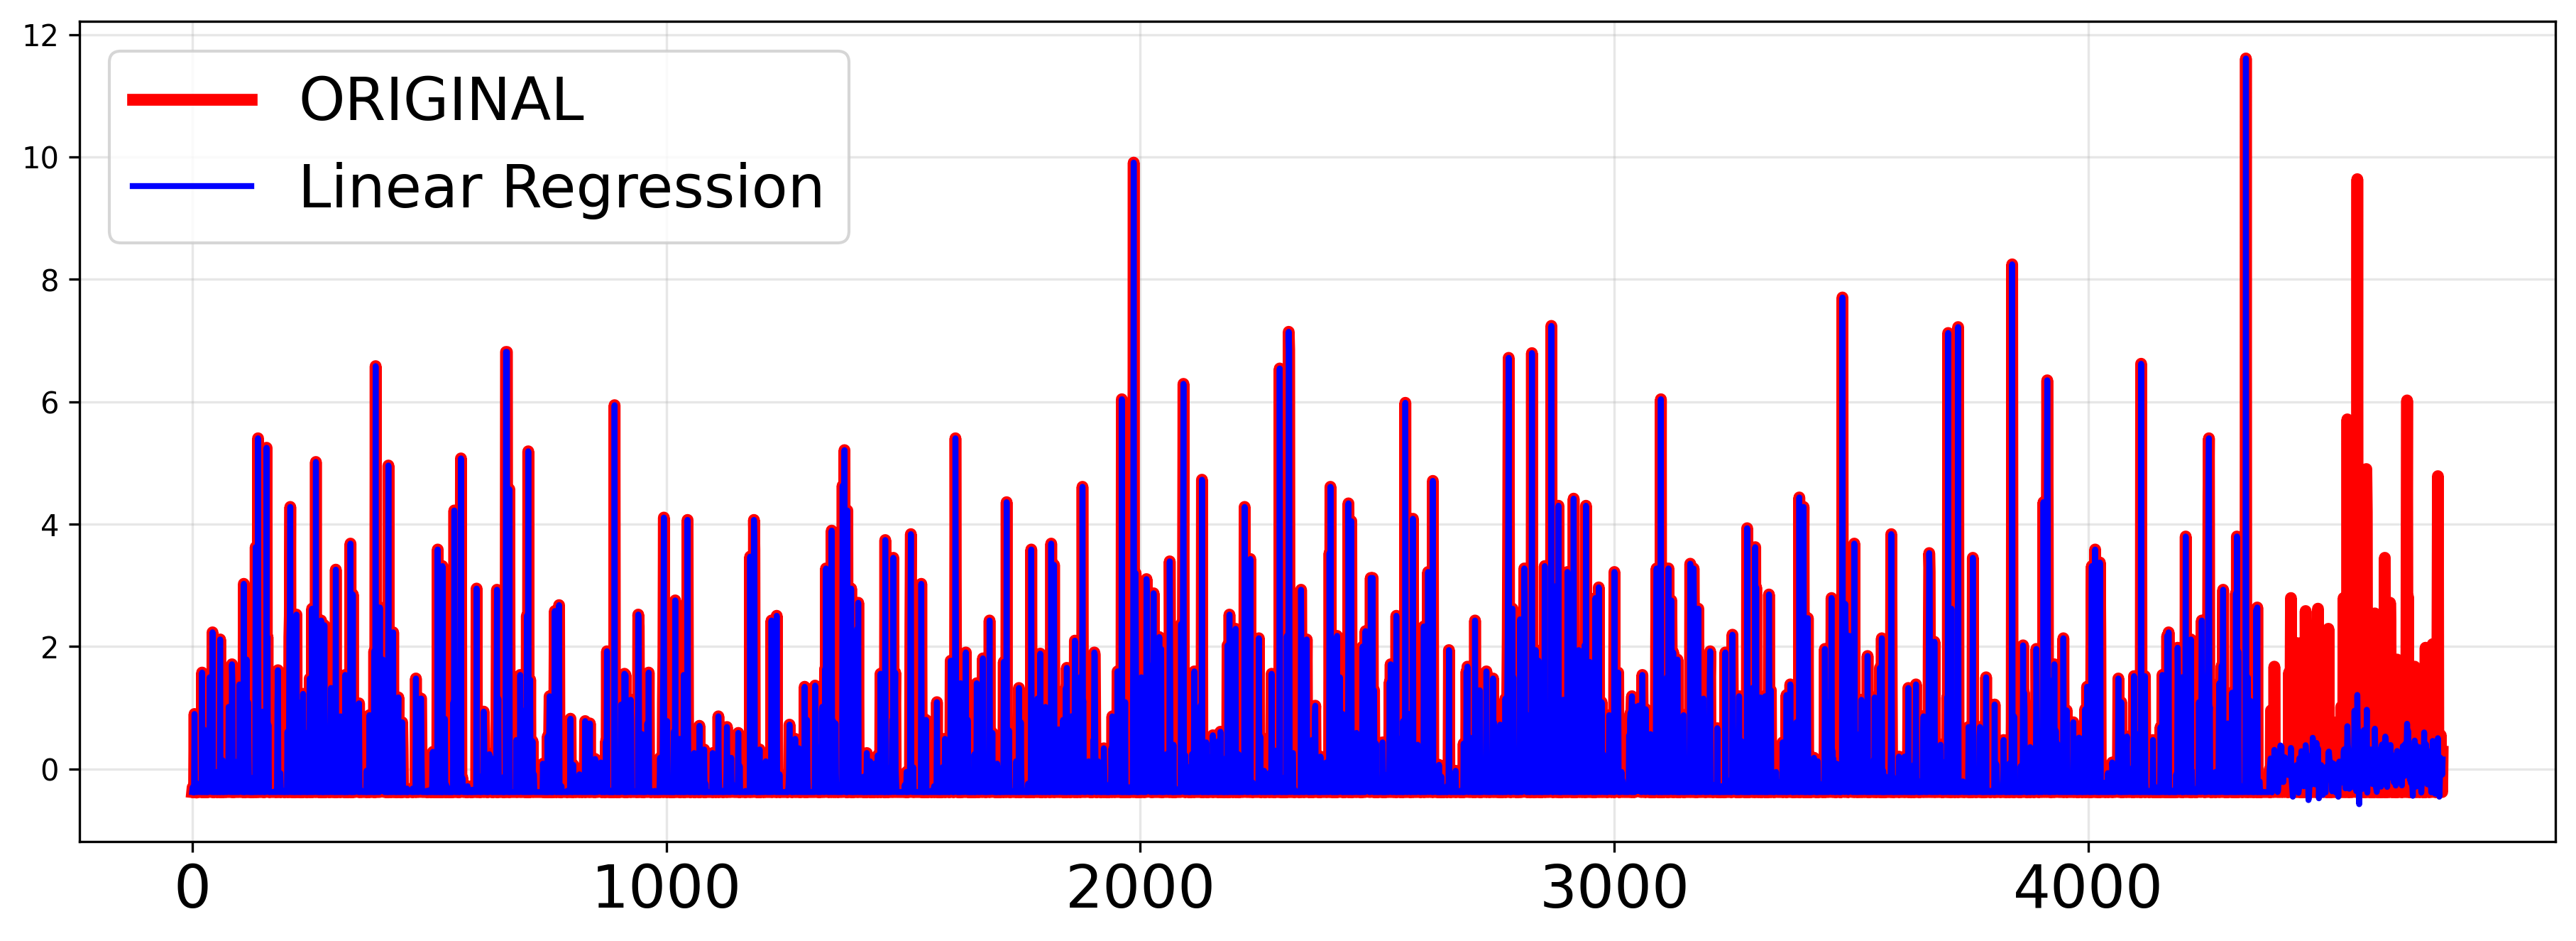

In [68]:
plot_grafico(series=[target_total_period, df_period_linear_regression['target']], labels=['ORIGINAL', 'Linear Regression'], lw_list=[4, 2], colors=['red', 'blue'])

In [69]:
predicted_value_linear_regression = df_period_linear_regression.iloc[-365:]['target'].apply(lambda x : x[0])

In [70]:
print_metricas_avaliacao(original_value, predicted_value_linear_regression)

MAE: 0.5235496604021699
MSE: 0.9395096451660215
RMSE: 0.9692830572985487
R2: 0.2277638027644232


In [71]:
original_value.describe()

count    365.000000
mean       0.093921
std        1.104514
min       -0.379604
25%       -0.379604
50%       -0.379604
75%       -0.031494
max        9.638222
Name: target, dtype: float64

## Random Forest

In [72]:
df_period_random_forest = predicao(sw_df, start_period_train, end_period_train, num_predict_periods, sliding_window_size, 'random_forest')

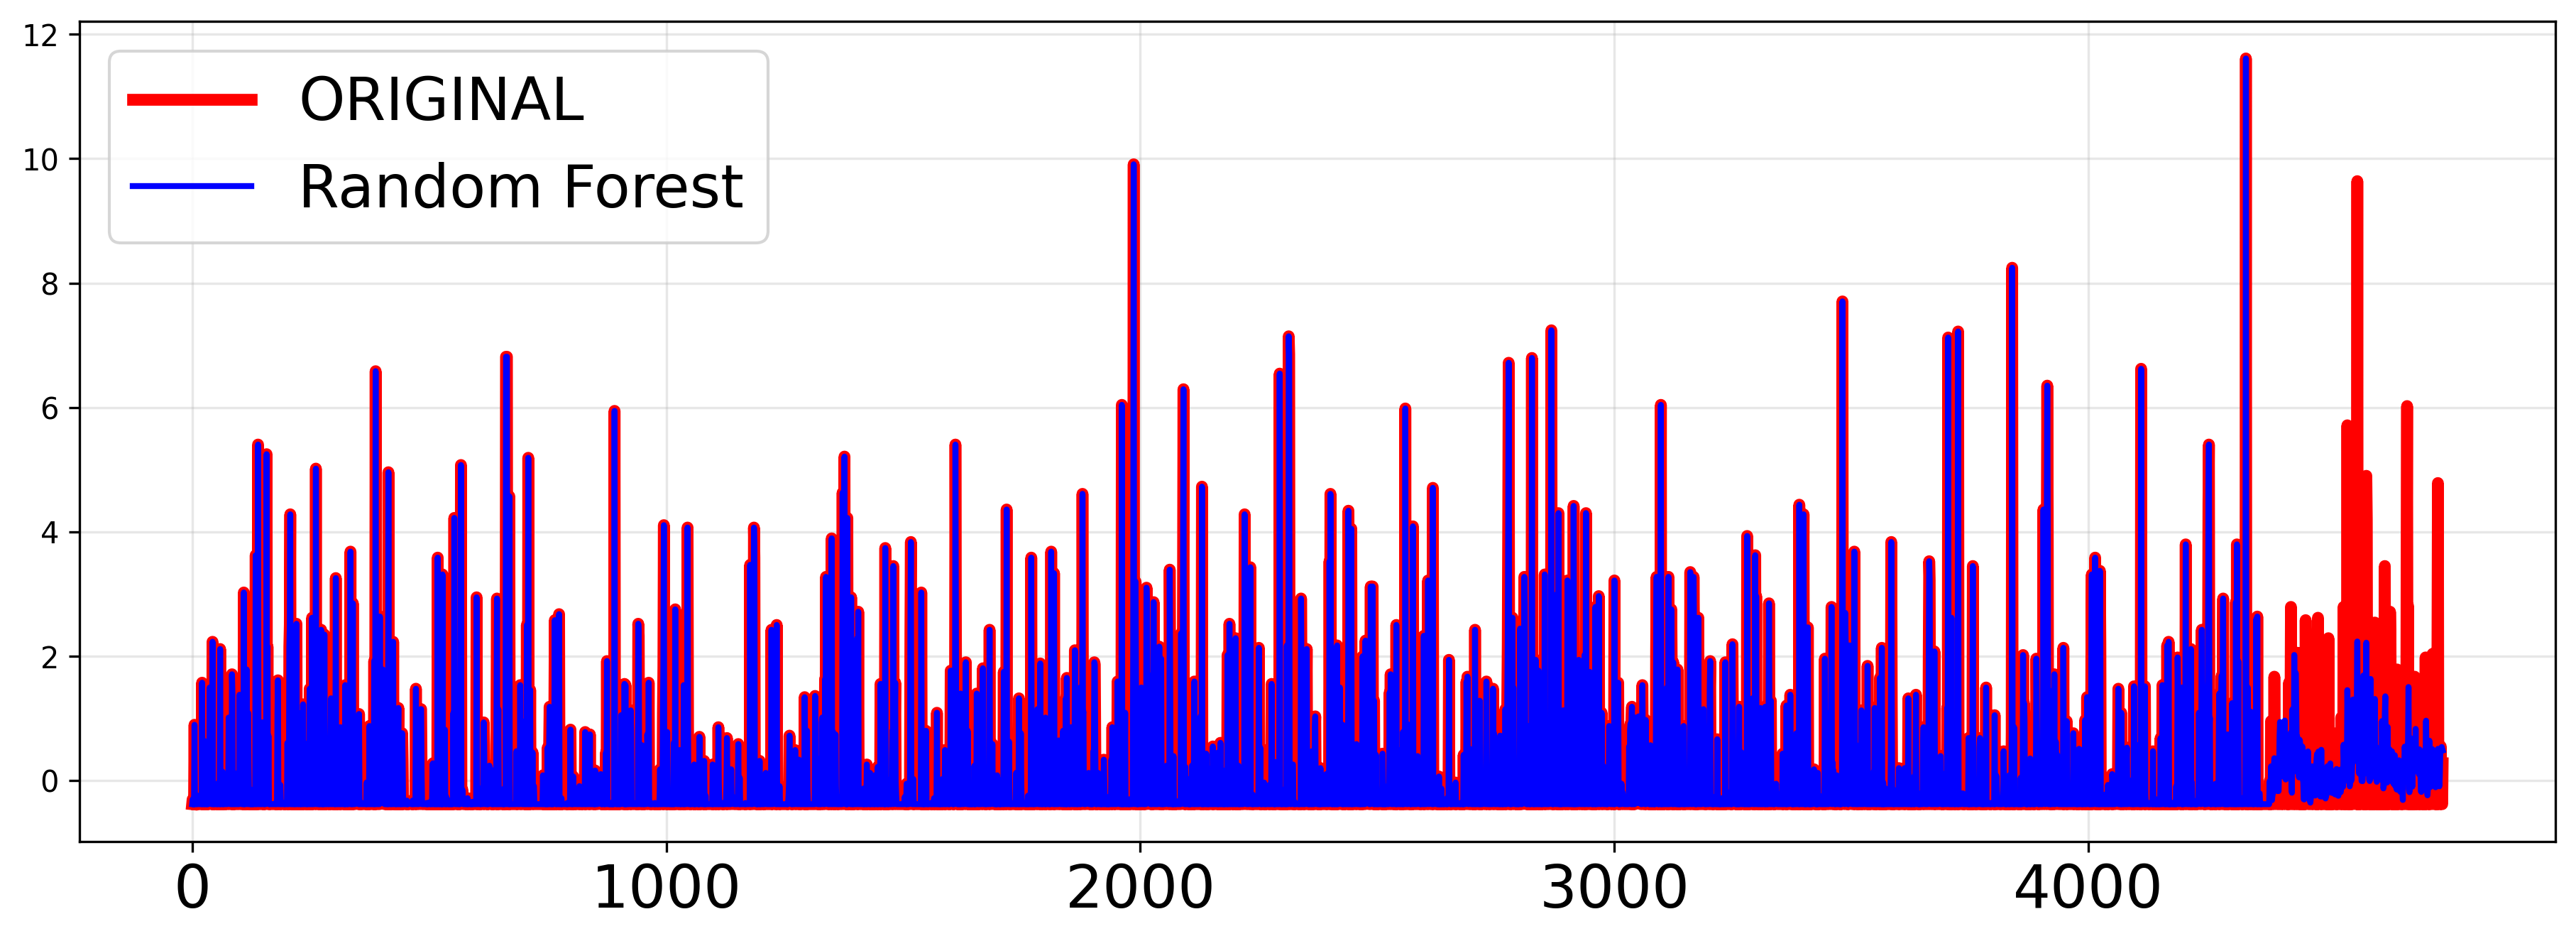

In [73]:
plot_grafico(series=[target_total_period, df_period_random_forest['target']], labels=['ORIGINAL', 'Random Forest'], lw_list=[4, 2], colors=['red', 'blue'])

In [74]:
predicted_value_random_forest = df_period_random_forest.iloc[-365:]['target'].apply(lambda x : x[0])

In [75]:
print_metricas_avaliacao(original_value, predicted_value_random_forest)

MAE: 0.6297618467294803
MSE: 0.9411582247440919
RMSE: 0.970133096406927
R2: 0.2264087418230485


In [76]:
original_value.describe()

count    365.000000
mean       0.093921
std        1.104514
min       -0.379604
25%       -0.379604
50%       -0.379604
75%       -0.031494
max        9.638222
Name: target, dtype: float64

# Interpretação resultados

In [111]:
df_teste = daily_df.loc[(daily_df.index > end_period_train) & (daily_df.index <= end_period_predict)]

In [112]:
df_teste = df_teste.reset_index(drop=True)

In [113]:
scaler = StandardScaler()
scaler.fit(df_teste[['precipitacao']])

StandardScaler()

## XGBRegressor

In [114]:
test_xgb = df_period_xgb.iloc[-365:].reset_index(drop=True)
test_xgb_inversed = scaler.inverse_transform(test_xgb[['target']])

In [ ]:
test_xgb_inversed

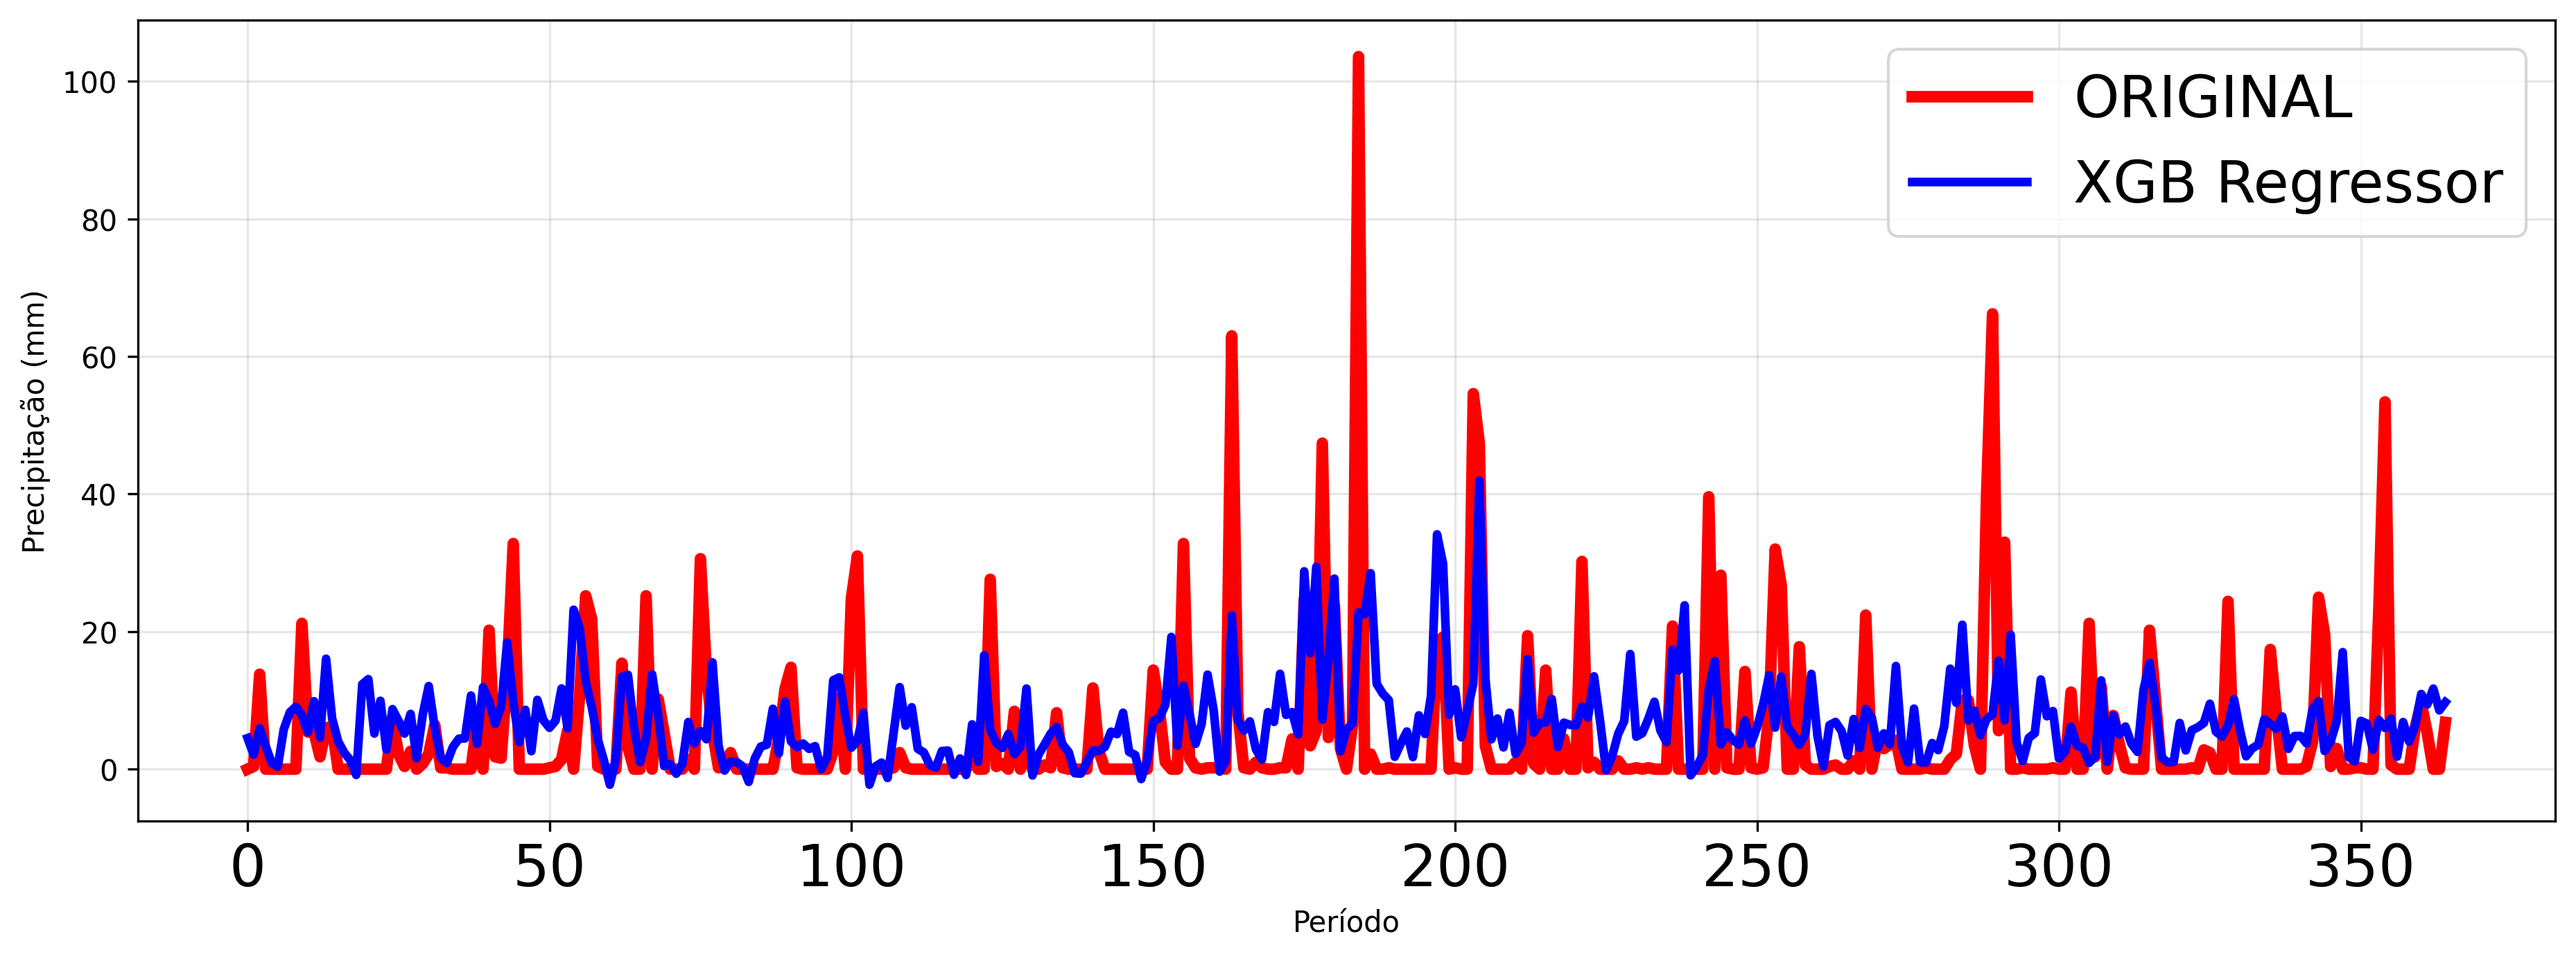

In [121]:
plot_grafico(series=[df_teste['precipitacao'], test_xgb_inversed], labels=['ORIGINAL', 'XGB Regressor'], lw_list=[4, 3], colors=['red', 'blue'], ylabel='Precipitação (mm)', xlabel='Período')

In [133]:
print_metricas_avaliacao(df_teste['precipitacao'], test_xgb_inversed)

MAE: 7.085233971805328
MSE: 120.4574310557289
RMSE: 10.975310066496021
R2: 0.07421537328876471


## Linear Regression

In [123]:
test_linear_regression = df_period_linear_regression.iloc[-365:].reset_index(drop=True)
test_linear_regression_inversed = scaler.inverse_transform(test_linear_regression[['target']])

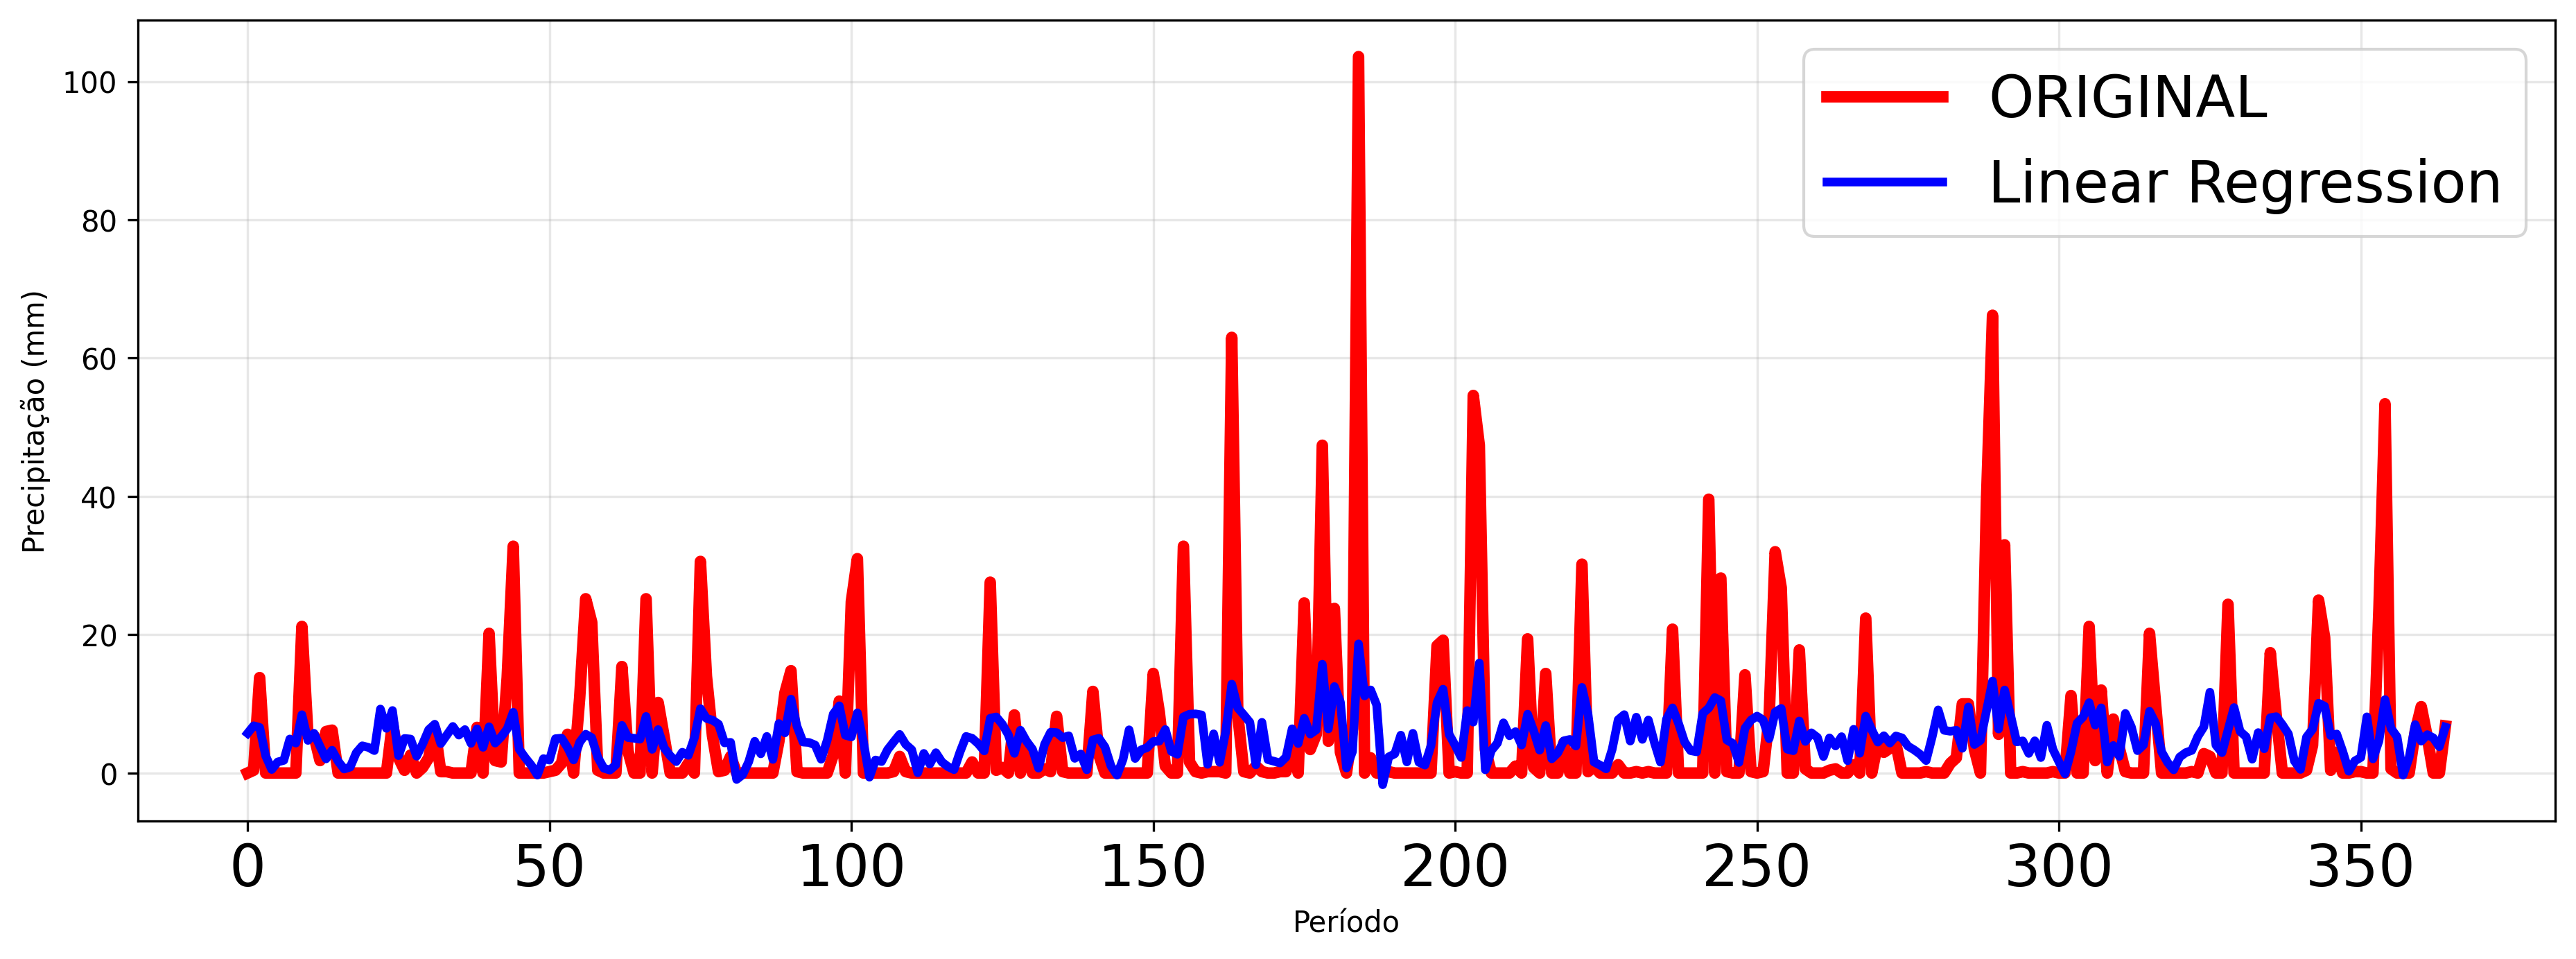

In [127]:
plot_grafico(series=[df_teste['precipitacao'], test_linear_regression_inversed], labels=['ORIGINAL', 'Linear Regression'], lw_list=[4, 3], colors=['red', 'blue'], ylabel='Precipitação (mm)', xlabel='Período')

In [132]:
print_metricas_avaliacao(df_teste['precipitacao'], test_linear_regression_inversed)

MAE: 5.830054315540119
MSE: 97.45362620792194
RMSE: 9.871860321536257
R2: 0.2510128418825648


## Random Forest

In [129]:
test_random_forest = df_period_random_forest.iloc[-365:].reset_index(drop=True)
test_random_forest_inversed = scaler.inverse_transform(test_random_forest[['target']])

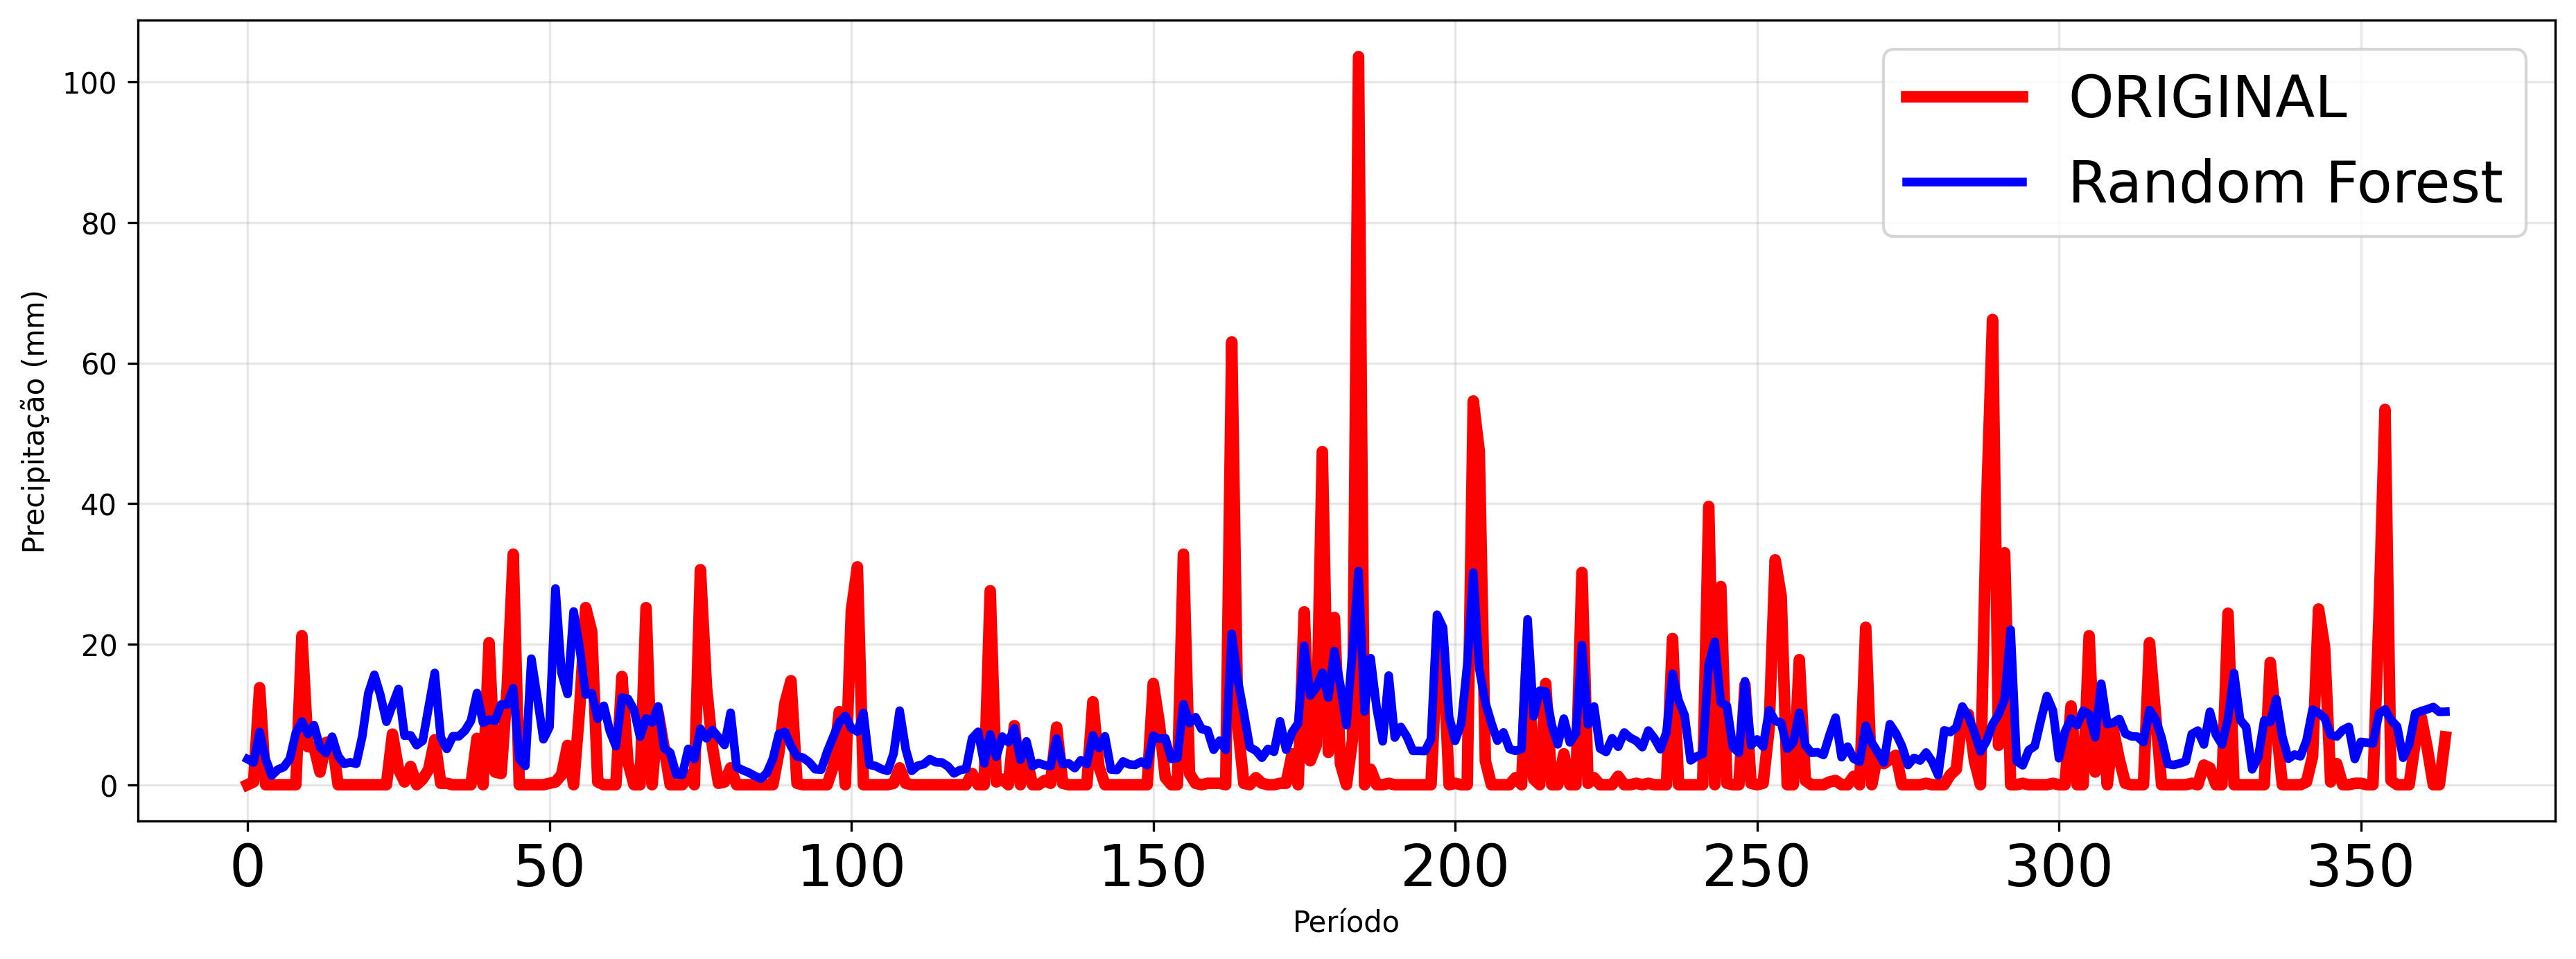

In [130]:
test_random_forest = df_period_random_forest['target'][-365:].reset_index(drop=True)
plot_grafico(series=[df_teste['precipitacao'], test_random_forest_inversed], labels=['ORIGINAL', 'Random Forest'], lw_list=[4, 3], colors=['red', 'blue'], ylabel='Precipitação (mm)', xlabel='Período')

In [131]:
print_metricas_avaliacao(df_teste['precipitacao'], test_random_forest_inversed)

MAE: 7.2503295946160256
MSE: 104.97731495054816
RMSE: 10.245843789095565
R2: 0.19318896739813152
